# Supervised Learning Project: Finding Donors for *CharityML*

## Project Background

CharityML is a fictitious charity organization located in the heart of Silicon Valley that was established to provide financial support for people eager to learn machine learning. After nearly 32,000 letters were sent to people in the community, CharityML determined that every donation they received came from someone that was making more than $50,000 annually. To expand their potential donor base, CharityML has decided to send letters to residents of California, but to only those most likely to donate to the charity. With nearly 15 million working Californians, CharityML has brought needs an algorithm to best identify potential donors and reduce overhead cost of sending mail.

### Goals

- How to identify when preprocessing is needed, and how to apply it.
- How to establish a benchmark for a solution to the problem.
- What each of several supervised learning algorithms accomplishes given a specific dataset.
- How to investigate whether a candidate solution model is adequate for the problem.

In this project, I employed several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal is to construct a model that accurately predicts whether an individual makes more than $50,000 USD. This task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Exploring the Data

The last column from this dataset, `'income'`, is the target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Importing Python 3 libraries necessary for project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell the percentage of these individuals making more than \$50,000. In the code cell below, I computed the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

The income entries are formatted like `'>50K'` and `'<=50K'`.

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == ">50K"].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == "<=50K"].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/n_records*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

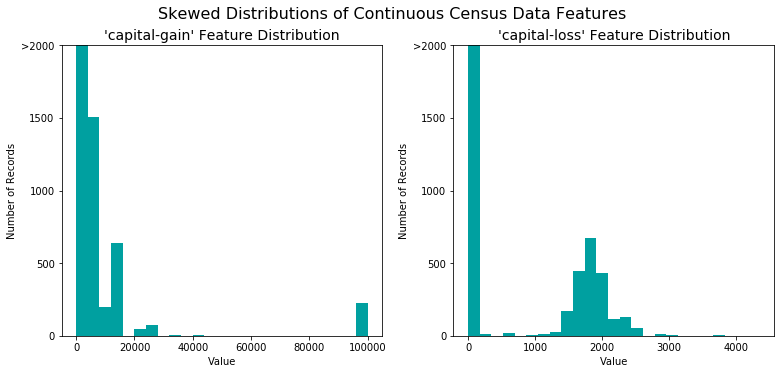

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, I applied a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

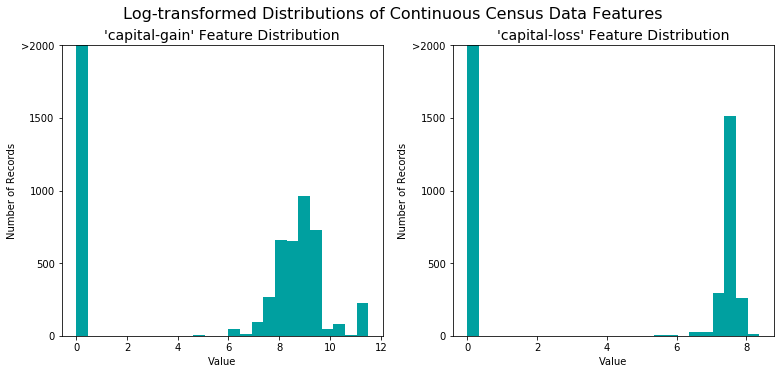

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

/Users/adcolony/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above shows that there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. Below, I implemented the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == ">50K" else 0)
              
# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, I will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, I will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That being said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


####  Accuracy vs Precision vs Recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.

It is a ratio of true positives (words classified as spam, and which are actually spam) to all positives (all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall (sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.

It is a ratio of true positives (words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in CharityML's case, if we had a 100 text messages and only 2 were spam and the remaining 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam (all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score (we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace

The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.


If a model that always predicts '1' (i.e. the individual makes more than 50k) then the model will have no True Negatives (TN) or False Negatives (FN) as it is not making any negative ('0' value) predictions. Therefore, the Accuracy in this case becomes the same as the Precision (True Positives/(True Positives + False Positives)) as every prediction made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. Also, the Recall score (True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
# Counting the ones, i.e. '>50K', as this is the naive case. 
# 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.

TP = np.sum(income)
print("True Positives:", TP)
FP = income.count() - TP # Specific to the naive case
print("False Positives:", FP)
TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = TP / (TP+FP)
recall = TP / (TP+FN) # which is 1
precision = accuracy

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1+beta**2)*(precision*recall)/((beta**2)*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

True Positives: 11208
Fale Positives: 34014
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may could be used for this type of problem:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

In [9]:
## Gaussian Naive Bayes (GaussianNB)
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(features_final, income).predict(features_final)
print("Number of mislabeled points out of a total %d points : %d"
      % (features_final.shape[0],(income != y_pred).sum()))

Number of mislabeled points out of a total 45222 points : 16978


### Model Application

I've decided to test three of the supervised learning models above on the census data. For each model chosen, I have also

- Described one real-world application in industry where the model can be applied. 
- Listed what the strengths of the model and when it performs well
- Stated the weaknesses of the model and when it performs poorly
- Informed what makes this model a good candidate for the problem

**Answer:**

All the models are classification models and thus could be used for classifying Californians into two income brackets.

**Ensemble Method - [`Gradient Boosting`](https://en.wikipedia.org/wiki/Gradient_boosting)**
- Describe one real-world application in industry where the model can be applied.

Gradient boosting can be applied in ranking algorithms like search engine results ranking. One such example is [`McRank`](https://papers.nips.cc/paper/3270-mcrank-learning-to-rank-using-multiple-classification-and-gradient-boosting.pdf).

- What are the strengths of the model; when does it perform well?

Gradient boosing is also good for large datasets, can reduce bias and variance, and can combine multiple weak predictors to build a strong predictor.

- What are the weaknesses of the model; when does it perform poorly?

Two weaknesses of gradient boosting is its relatively high training time and its over-fitting if the data sample is too small.

- What makes this model a good candidate for the problem, given what you know about the data?

Gradient boosting works as a good candidate because the data we have is sufficiently large and clean so the weaknesses of the approach will not occur.

**Ensemble Method - [`Random Forest`](https://en.wikipedia.org/wiki/Random_forest)**
- Describe one real-world application in industry where the model can be applied. 

One example of real-world application of random forest is to identify dieases based on symptoms; such as [`Alzheimers`](https://www.sciencedirect.com/science/article/pii/S2213158214001326).


- What are the strengths of the model; when does it perform well?

Random Forests are good for large datasets, giving estimates of feature's importance, and can be run in parallel to speed up training, and can be used to reduce variance caused by decision trees by combining multiple decision trees.

- What are the weaknesses of the model; when does it perform poorly?

A weakness of random forests is the high prediction time.

- What makes this model a good candidate for the problem, given what you know about the data?

Random forests have good performance with categorical variables even with 45,000 entries like this problem has.

**Logistic Regression**
- Describe one real-world application in industry where the model can be applied. 

Logistic regression is commonly used in binary classification problems such as weather a user will buy a product or not or install an app or not. For example, models to predict an install from companies like [`AdColony`](https://www.adcolony.com/) or [`Vungle`](https://www.vungle.com/).

- What are the strengths of the model; when does it perform well?

Two benefits of logistic regression is that it is fast in training and prediction time and gives good results in case of less features. It also is very common and is generally easier to understand when communicating to non-technical stakeholders.

- What are the weaknesses of the model; when does it perform poorly?

The disadvantages of logistic regresssion is that it assumes a linear decision boundary and cannot decode complex relationships between features.

- What makes this model a good candidate for the problem, given what you know about the data?

The problem's clean data and binary classification are favourable conditions for logistic regression.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, it's important that to create a training and predicting pipeline that allows one to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

Below, I've:
 - Fitted the learner to the sampled training data and recorded the training time.
 - Performed predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Recorded the total prediction time.
 - Calculated the accuracy score for both the training subset and testing set.
 - Calculated the F-score for both the training subset and testing set.
   - Set the `beta` parameter

In [10]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # end time
    
    results['train_time'] = end - start
        
    # Get predictions on the test set(X_test)
    # then get predictions on the first 300 training samples(X_train)
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell below, I implemented the following:
- Imported the three aforementioned supervised learning models
- Initialized the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Usec a `'random_state'` for each model you use, if provided.
- Calculated the number of records equal to 1%, 10%, and 100% of the training data.

GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.


/Users/adcolony/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.


/Users/adcolony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/adcolony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/adcolony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 36177 samples.


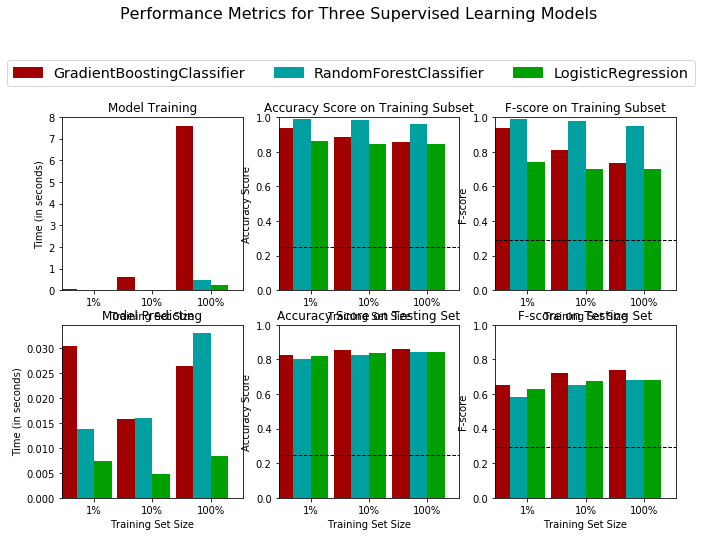

In [11]:
from sklearn.ensemble import GradientBoostingClassifier #clf_A
from sklearn.ensemble import RandomForestClassifier #clf_B
from sklearn.linear_model import LogisticRegression #clf_C


# Initialize the three models
clf_A = GradientBoostingClassifier(random_state=7)
clf_B = RandomForestClassifier(random_state=7)
clf_C = LogisticRegression(random_state=7)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(y_train))
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, I chose from the three supervised learning models the *best* model to use on the data. I then performed a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

Out of the three tried models, the Gradient Boosting Classifier had the highest accuracy and F-score regardless of training set size. This means that the model is able to give good results for both recall and precision. While the model predicting time for Gradient Boosting was the highest for training time, at 100% set size, prediction time was lower than Random Forest Classifier.

### Describing the Model in Layman's Terms

To predict whether an individual earns $50k USD or more, a supervised machine learning model was created. After three different models were tried and compared, the Gradient Boosting Classifier method was chosen. Gradient Boosing is an ensemble technique which means that predictions are done by an group of simpler estimators. It works by combining several simple learings, such as decision trees, to create an ensemble of learners than can predict our binary classification. A decision tree is a tree-shaped diagram (if drawn) that on each branch displays the possible options for a specific item. For example, one branch might be gender and the options could be male or female; and the next branch could split females into below or above the median age. In this problem, each of the learners are created using "features" of individuals, such as race, gender, education..., to create a set of rules that can predict a person's income.

During the training process, the algorithm looks at instances where it has predicted poorly (weak learners), and prioritizes the prediction of those instances in the next round of training. With each round, the model finds the best learner (or decision tree) to incorporate into the ensemble, repeating the process for a specified number of rounds, or until it can't improve the prediction further. All the learners are then combined to make a final ensembled model where they each vote to predict if a person earns more than 50k USD or not. Usually, the majority of the votes is used to make the final prediction. Using this model with the census info, CharityML will be able to predict the same info for a potential new donor and predict if the potential donor makes more than $50k and thus determine the likeliness of them donating to the charity.

### Implementation: Model Tuning

In [12]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import r2_score, fbeta_score, make_scorer

# Initialize the classifier
clf = GradientBoostingClassifier(random_state = 7)

# Create the parameters list you wish to tune using a dictionary
parameters = {'n_estimators': [100, 300, 500], 'learning_rate': [0.1, 1, 1.3]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/Users/adcolony/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8719
Final F-score on the testing data: 0.7547


### Final Model Evaluation

### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8630          |   0.8719        |
| F-score        |   0.7395          |   0.7547        |


As expected the optimized model scores are better than the unoptimized model. The accuracy score is 1.03% better and the F-score is 2.06% better. The naive predictor benchmark scores were 0.2478 for accuracy and 0.2917 for f-score. The optimized model is 251.86% better.

----
## Feature Importance

An important task when performing supervised learning on a dataset, like the census data, is determining which features provide the most predictive power.

###  Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.

Of these thirteen records, the five features that I would expect to be most important for prediction in the order of importance are:

1. Capital-Gain because it directly relates to how much money an individual is making. The larger the capital gain, the higher the likelihood I would expect the individual would be able to donate.

2. Education-num because it would provide insight into how educated an individual is, and the expectation is that the higher the education, then the higher the income. However, it is last in this list because education does not always correlate to certain jobs.

3. Capital-Loss because it is the total loss suffered by an individual and for the inverse reason of capital gain.

4. Occupation because income highly correlates to an individual's occupation.

5. Age because more experienced/older people oftern earn more than younger people.


### Implementation - Extracting Feature Importance

In the code cell below, I implemented the following:
 - Imported a supervised learning model from sklearn if it is different from the three used earlier.
 - Trained the supervised model on the entire training set.
 - Extracted the feature importances using `'.feature_importances_'`.

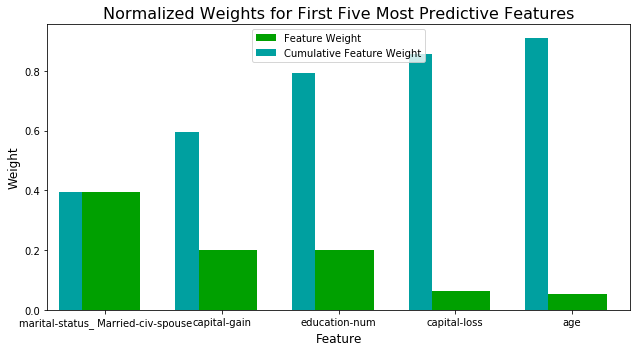

In [13]:
# Import a supervised learning model that has 'feature_importances_'
# GradientBoostingClassifier was imported in a previous code block 
# from sklearn.ensemble import GradientBoostingClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

Except for marital status, the five features match up with my expectations. Marital status was something I thought would be in the top, but I expectated it to be at number 6.
Occupation does not cause as much effect on income as I expected.

Regarding the order, if you remove occupation and add marital status at the beginning, then the ranking matches.


### Feature Selection

With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8719
F-score on testing data: 0.7547

Final Model trained on reduced data
------
Accuracy on testing data: 0.8589
F-score on testing data: 0.7257


### Effects of Feature Selection

If training time was a factor, I would definitely consider using the reduced data, expectionally since the prompt is about a low-harm question of who will donate. The reduced data only decreased the f-score by 3.8%.